In [27]:
import os, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image


In [28]:
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s):")
        for g in gpus:
            print("   ", g)
    except Exception as e:
        print("Could not set memory growth:", e)
else:
    print("No GPU found — running on CPU.")


Enabled memory growth for 2 GPU(s):
    PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
    PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [29]:
# ============================================================
# 3️⃣ PATHS & LOAD MODEL
# ============================================================
BASE_DIR = Path("/kaggle/input")  # Kaggle auto-mounts your uploaded files here
DATASET_DIR = BASE_DIR / "fer2013-preprocessed-new/fer2013_processed_new"   # <-- change this to your uploaded dataset folder
MODEL_PATH = BASE_DIR / "best-model"/"best_model.keras"
HISTORY_CSV = BASE_DIR / "model-history"/"history.csv"

print("Loading model...")
model = keras.models.load_model(MODEL_PATH)
print("Model loaded successfully!")
model.summary(line_length=120)


Loading model...
Model loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 192 variables whereas the saved optimizer has 196 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "MiniMobileNetV2_a0.75_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input (InputLayer)                │ (None, 160, 160, 3)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ cast_3 (Cast)                     │ (None, 160, 160, 3)          │                 0 │ input[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ stem_conv (Conv2D)                │ (None, 80, 80, 12)           │               324 │ cast_3[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ stem_bn (BatchNormalization)      │ (None, 80, 80, 12)           │                48 │ stem_conv[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu (ReLU)                      │ (None, 80, 80, 12)           │                 0 │ stem_bn[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b1_dw (DepthwiseConv2D)           │ (None, 80, 80, 12)           │               108 │ re_lu[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b1_dw_bn (BatchNormalization)     │ (None, 80, 80, 12)           │                48 │ b1_dw[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_1 (ReLU)                    │ (None, 80, 80, 12)           │                 0 │ b1_dw_bn[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b1_proj (Conv2D)                  │ (None, 80, 80, 12)           │               144 │ re_lu_1[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b1_proj_bn (BatchNormalization)   │ (None, 80, 80, 12)           │                48 │ b1_proj[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b1_add (Add)                      │ (None, 80, 80, 12)           │                 0 │ re_lu[0][0], b1_proj_bn[0]
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b2_exp (Conv2D)                   │ (None, 80, 80, 48)           │               576 │ b1_add[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b2_exp_bn (BatchNormalization)    │ (None, 80, 80, 48)           │               192 │ b2_exp[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_2 (ReLU)                    │ (None, 80, 80, 48)           │                 0 │ b2_exp_bn[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b2_dw (DepthwiseConv2D)           │ (None, 40, 40, 48)           │               432 │ re_lu_2[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ b2_dw_bn (BatchNormalization)     │ (None, 40, 40, 48)           │               192 │ b2_dw[0][0]               
├───────────────────────────────────┼───────────────────

 Total params: 1,099,481 (4.19 MB)

 Trainable params: 363,497 (1.39 MB)

 Non-trainable params: 8,988 (35.11 KB)

 Optimizer params: 726,996 (2.77 MB)

In [30]:
# ============================================================
# 4️⃣ LOAD TEST DATA (CSV)
# ============================================================
test_df = pd.read_csv(DATASET_DIR / "test.csv")
test_df = test_df.rename(columns={"emotion":"label", "class":"label", "path":"filepath"})
test_df["filepath"] = test_df["filepath"].apply(lambda p: (DATASET_DIR / p).as_posix())

classes = sorted(test_df["label"].unique().tolist())
class2id = {c:i for i,c in enumerate(classes)}
id2class = {i:c for c,i in class2id.items()}
test_df["label_id"] = test_df["label"].map(class2id).astype(int)
NUM_CLASSES = len(classes)

print(f"Classes ({NUM_CLASSES}): {classes}")
print(f"Total test images: {len(test_df)}")


Classes (5): ['angry', 'happy', 'neutral', 'sad', 'surprise']
Total test images: 6043


In [31]:
# ============================================================
# 5️⃣ PREPROCESSING PIPELINE (same as training)
# ============================================================
IMG_SIZE = 160
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Convert Windows "\" paths → Linux "/" and join with dataset root
test_df["filepath"] = (
    test_df["filepath"]
    .astype(str)
    .str.replace("\\", "/", regex=False)
    .apply(lambda p: str(Path(DATASET_DIR / Path(p).name)) 
           if not Path(p).is_absolute() else str(Path(p).as_posix()))
)

def decode_and_resize(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img

def make_example(path, label_id):
    return decode_and_resize(path), tf.cast(label_id, tf.int32)

def make_ds(df, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((df["filepath"], df["label_id"]))
    if shuffle:
        ds = ds.shuffle(len(df), seed=42)
    ds = ds.map(make_example, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

def to_one_hot(ds, n_classes):
    return ds.map(lambda x,y: (x, tf.one_hot(y, n_classes)), num_parallel_calls=AUTOTUNE)

test_ds = make_ds(test_df, shuffle=False)
test_ds_oh = to_one_hot(test_ds, NUM_CLASSES)


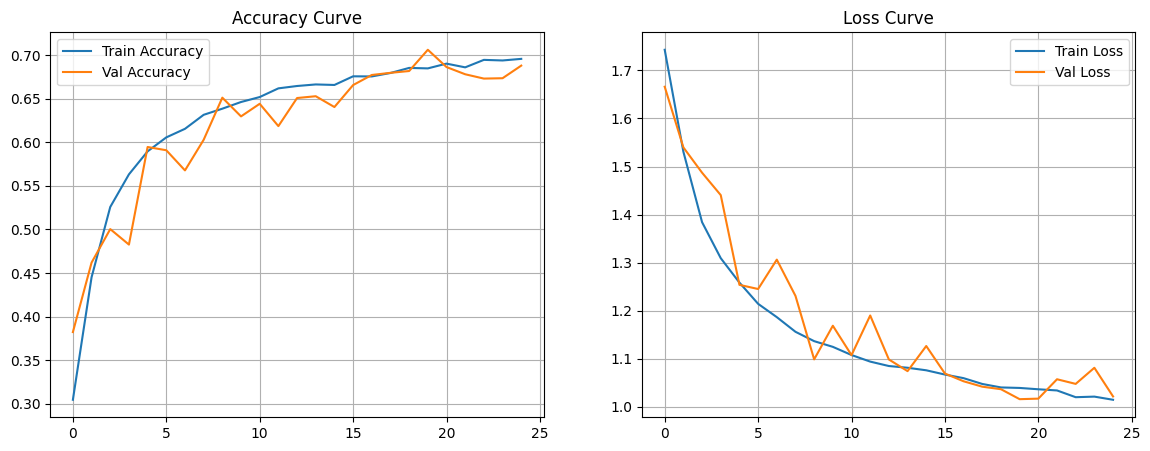

In [32]:
# ============================================================
# 6️⃣ HISTORY VISUALIZATION
# ============================================================
if HISTORY_CSV.exists():
    history = pd.read_csv(HISTORY_CSV)
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history["accuracy"], label="Train Accuracy")
    plt.plot(history["val_accuracy"], label="Val Accuracy")
    plt.title("Accuracy Curve"); plt.legend(); plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(history["loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss Curve"); plt.legend(); plt.grid(True)
    plt.show()
else:
    print(" history.csv not found.")


Evaluating on test set...
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step
Predictions: 6043, Ground truth: 6043


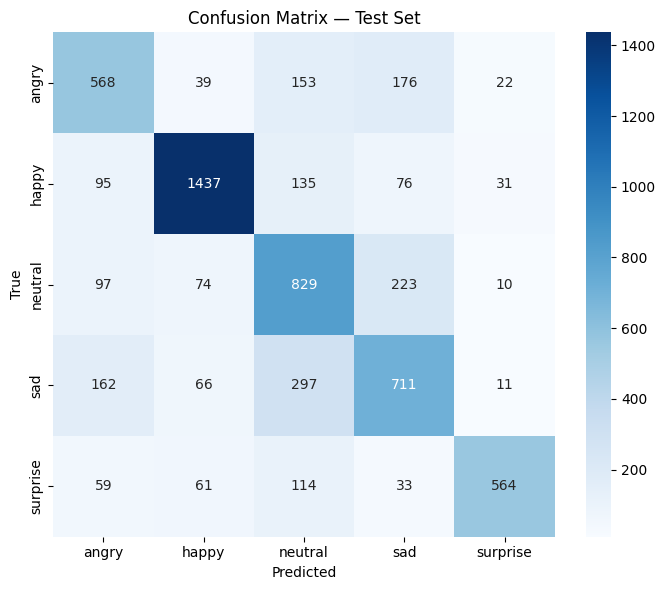


Classification Report:
              precision    recall  f1-score   support

       angry       0.58      0.59      0.59       958
       happy       0.86      0.81      0.83      1774
     neutral       0.54      0.67      0.60      1233
         sad       0.58      0.57      0.58      1247
    surprise       0.88      0.68      0.77       831

    accuracy                           0.68      6043
   macro avg       0.69      0.66      0.67      6043
weighted avg       0.70      0.68      0.68      6043


Per-Class Accuracy:
angry     : 59.29%
happy     : 81.00%
neutral   : 67.23%
sad       : 57.02%
surprise  : 67.87%

Mean Per-Class Accuracy: 66.48%


In [33]:
# ============================================================
# 7️⃣ CONFUSION MATRIX + REPORT  ✅ FIXED VERSION
# ============================================================
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("Evaluating on test set...")

# --- Predict safely (limit steps to dataset length)
steps = int(np.ceil(len(test_df) / BATCH_SIZE))
probs = model.predict(test_ds_oh, steps=steps, verbose=1)

# --- Ensure shapes align
y_pred = np.argmax(probs, axis=1)
y_true = test_df["label_id"].to_numpy()

print(f"Predictions: {len(y_pred)}, Ground truth: {len(y_true)}")

# --- If mismatch due to partial batch, trim the longer array
min_len = min(len(y_pred), len(y_true))
y_pred = y_pred[:min_len]
y_true = y_true[:min_len]

# --- Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix — Test Set")
plt.tight_layout(); plt.show()

# --- Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# --- Per-Class Accuracy (safe division)
with np.errstate(divide='ignore', invalid='ignore'):
    class_acc = np.nan_to_num(cm.diagonal() / cm.sum(axis=1))

print("\nPer-Class Accuracy:")
for i, acc in enumerate(class_acc):
    print(f"{classes[i]:<10}: {acc*100:.2f}%")

# --- Optional: print average accuracy across classes
print(f"\nMean Per-Class Accuracy: {np.mean(class_acc)*100:.2f}%")



In [37]:
# ============================================================
# 8️⃣ FINAL METRICS SUMMARY (clean output)
# ============================================================
print("\nEvaluating model on test set...\n")

results = model.evaluate(test_ds_oh, verbose=0, return_dict=True)

test_loss = results.get("loss", np.nan)
test_acc = results.get("accuracy", np.nan)
test_top3 = results.get("top3", np.nan)  # if you have top-3 metric
test_auc = results.get("auc", np.nan) if "auc" in results else None


print("TEST SET RESULTS")

print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
if test_top3:
    print(f"Top-3 Accuracy:{test_top3:.4f} ({test_top3*100:.2f}%)")
if test_auc is not None:
    print(f"Test AUC:      {test_auc:.4f}")
print("="*60)



Evaluating model on test set...

TEST SET RESULTS
Test Loss:     1.0380
Test Accuracy: 0.6800 (68.00%)
Top-3 Accuracy:0.9482 (94.82%)


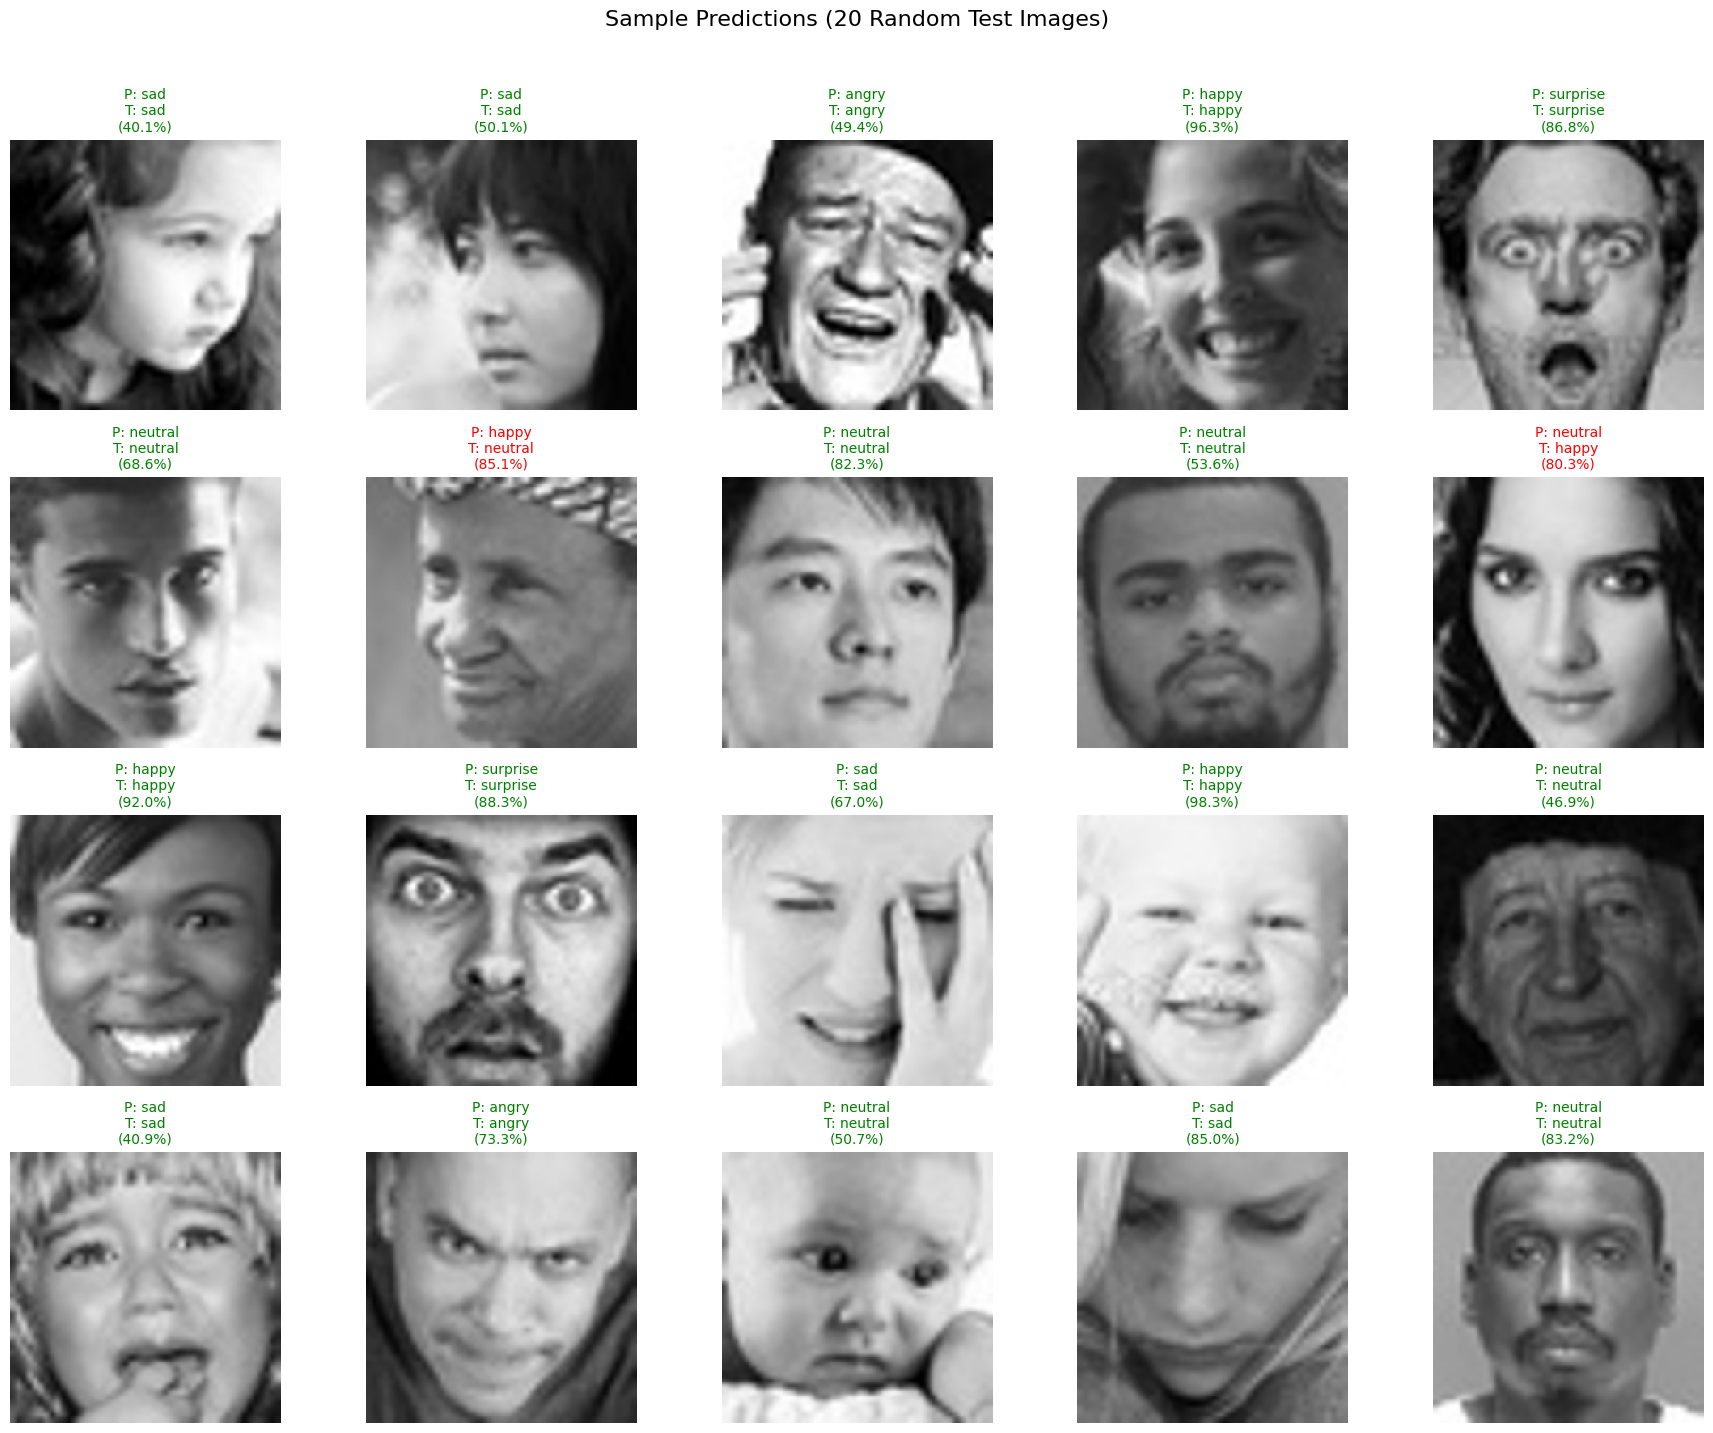

In [35]:
# ============================================================
# ============================================================
# 8️⃣ SAMPLE PREDICTIONS (20 samples, 5 per row)
# ============================================================
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random
import numpy as np

num_samples = 20
cols = 5
rows = int(np.ceil(num_samples / cols))

plt.figure(figsize=(18, 14))
indices = random.sample(range(len(test_df)), k=min(num_samples, len(test_df)))

for i, idx in enumerate(indices):
    img_path = test_df.iloc[idx]["filepath"]
    true_label = classes[int(test_df.iloc[idx]["label_id"])]

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = image.img_to_array(img) / 255.0

    # Predict
    pred = model.predict(np.expand_dims(arr, axis=0), verbose=0)[0]
    pred_label = classes[int(np.argmax(pred))]
    confidence = np.max(pred) * 100

    # Plot
    plt.subplot(rows, cols, i + 1)
    plt.imshow(arr)
    color = "green" if pred_label == true_label else "red"
    plt.title(
        f"P: {pred_label}\nT: {true_label}\n({confidence:.1f}%)",
        color=color, fontsize=10
    )
    plt.axis("off")

plt.suptitle("Sample Predictions (20 Random Test Images)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()



In [36]:
# ============================================================
# 9️⃣ FINAL SUMMARY
# ============================================================
test_metrics = model.evaluate(test_ds_oh, verbose=0, return_dict=True)
test_acc = test_metrics.get("accuracy", np.nan)
test_loss = test_metrics.get("loss", np.nan)

print("\nFINAL EVALUATION SUMMARY")
print(f"Test Accuracy : {test_acc:.4f}")
print(f"Test Loss     : {test_loss:.4f}\n")

print("Per-Class Accuracy:")
for i, acc in enumerate(class_acc):
    print(f" - {classes[i]:<10}: {acc*100:.2f}%")

print("\nEvaluation complete.")



FINAL EVALUATION SUMMARY
Test Accuracy : 0.6800
Test Loss     : 1.0380

Per-Class Accuracy:
 - angry     : 59.29%
 - happy     : 81.00%
 - neutral   : 67.23%
 - sad       : 57.02%
 - surprise  : 67.87%

Evaluation complete.
